<div style="text-align: center;">
<a target="_blank" href="https://colab.research.google.com/github/bmalcover/aa_2425/blob/main/10_VGG_Custom_Dataset/VGG_Custom.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

In [12]:
import os

import torch
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import cv2

# Introducció

En aquesta pràctica treballarem amb l'arquitectura ResNet (Residual Network), centrant-nos en el concepte clau dels blocs residuals, que ja hem explorat a classe. Recordem breument la principal innovació d'aquestes: el bloc residual. Aquest introdueix una connexió directa (*shortcut connection*) entre l'entrada i la sortida d'un grup de capes, tal com es representa a continuació:

$$
\mathbf{y} = \mathcal{F}(\mathbf{x}, \{W_i\}) + \mathbf{x}
$$

On:
- $\mathbf{x}$ és l'entrada del bloc.
- $\mathcal{F}(\mathbf{x}, \{W_i\})$ és la transformació no lineal aplicada per les capes internes (normalment convolucions, normalització i ReLU).
- $\mathbf{y}$ és la sortida, que combina l'entrada original xx amb la transformació.

Aquest simple però efectiu mecanisme permet que el model "aprengui" només la diferència (o residual) entre l'entrada i la sortida esperada, en lloc de l'objectiu complet. Això facilita l'entrenament i redueix el risc de degradació del rendiment en xarxes profundes.

A classe hem vist que aquests blocs residuals són la base de diferents variants de ResNet, com ara ResNet-18, ResNet-50, etc., amb diferències en la profunditat i el nombre de blocs. Ara posarem en pràctica aquest coneixement treballant amb ResNets per a tasques de classificació d’imatges

# Cream mòduls amb Pytorch

En aquesta pràctica aprendrem a definir mòduls personalitzats en PyTorch utilitzant la classe base ``torch.nn.Module``. Aquesta classe permet encapsular les capes i operacions d’una xarxa neuronal, facilitant-ne la reutilització i el manteniment.

**Pasos per crear un mòdul en Pytorch:**
1. **Heretar de nn.Module**. Tots els mòduls personalitzats en PyTorch han de derivar de la classe base torch.nn.Module.
2. **Definir les capes en el constructor __init__.** Al constructor del mòdul (__init__), s’han d’inicialitzar les capes que s’utilitzaran, com ara convolucions, capes lineals o funcions d’activació.
3. **Implementar la funció forward.** Aquesta funció defineix com flueixen les dades a través del mòdul. Aquí s’apliquen les capes definides al constructor de manera seqüencial o segons sigui necessari.


## Cream un bloc residual


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding='same',
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding='same',
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=(3, 3),
                    padding='same',
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x) if self.downsample else x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x + identity)

        return x

## Una VGG16 residual

Una vegada el tenim implementat farem dos models:
1. Model VGG16 **normal**. Un model com el que vàrem veure la setmana passada sense preentranement.
2. Model VGG16 **ampliat**. Heu d'afegir a una VGG16 dos blocs residuals al final de l'extractor de característiques. Per fer-ho s'ha d'emprar la mateixa estratègia que heu vist a les sessions anteriors per fer fine-tunning.

Entrena ambdós models amb el conjunt de dades [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), i contesta a la següent pregunta:

- És el mateix resultat una xarxa que l'altra? Si és així o no diguès per què?

## Llegim les dades

In [3]:
DOWNLOAD = True
BATCH_SIZE = 64
EPOCHS = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64))
])


train= datasets.FashionMNIST("./data", train=True, download=DOWNLOAD, transform=transform)
test=datasets.FashionMNIST("./data", train=False, download=DOWNLOAD, transform=transform)

train_loader = torch.utils.data.DataLoader(train, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, BATCH_SIZE)

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 10.8MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 653kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:00<00:00, 6.81MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 4.97MB/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
img, target = next(iter(train_loader))
print(img.shape, target)

torch.Size([64, 1, 64, 64]) tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])


## Carregam el model

Posam weights a ``False`` perquè volem entrenar de 0.

In [5]:
vgg11 = models.vgg11(weights=False)
vgg11

C:\Users\Toni\miniconda3\envs\iaToni2024\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## Afegim els blocs residuals

In [6]:
vgg11.features.append(ResidualBlock(512, 512))
vgg11.features.append(ResidualBlock(512, 512))
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Adaptam el model

El model l'hem d'aptar per imatges en escala de grisos i per prediure 10 classes enlloc de 1000.

In [7]:
vgg11.features[0] = torch.nn.Conv2d(in_channels= 1, out_channels=64, kernel_size=(3,3), stride=1, padding="same")
vgg11.classifier[-1] = torch.nn.Linear(4096, 10)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg11.to(device)

## Entrenament

In [9]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(vgg11.parameters(), lr=learning_rate)

In [10]:
from sklearn.metrics import accuracy_score

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc_cnn = []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0

    i_batch = 1
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
        vgg11.train()  # Posam el model a mode entranament.

        optimizer.zero_grad()

        # 1. PREDICCIÓ
        y_pred = vgg11(x.to(device))

        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        y = y.to(device)

        loss = loss_fn(y_pred, y)

        #3. GRADIENT
        vgg11.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()

        # 5. EVALUAM EL MODEL
        vgg11.eval()  # Mode avaluació de la xarxa

        y_pred = vgg11(x.to(device))
        batch_loss += (loss_fn(y_pred, y).detach())

        y_pred_class = torch.argmax(y_pred.detach().cpu(), dim=1).numpy()
        batch_acc += accuracy_score(y.detach().cpu().numpy() , y_pred_class)

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0

    vgg11.eval()
    for i_batch, (x, y) in enumerate(test_loader):
        y_pred = vgg11(x.to(device))
        batch_test_loss += (loss_fn(y_pred, y.to(device)).detach())

        y_pred_class = torch.argmax(y_pred.detach().cpu(), dim=1).numpy()
        batch_test_acc += accuracy_score(y, y_pred_class)

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc_cnn.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

In [14]:
cpu_running_loss = [t.cpu() for t in running_loss]
cpu_running_test_loss = [t.cpu() for t in running_test_loss]

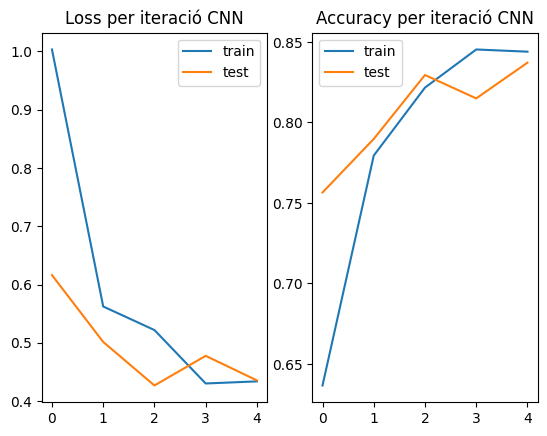

In [16]:
plt.subplot(1,2,1)
plt.title("Loss per iteració CNN")
plt.plot(cpu_running_loss, label="train")
plt.plot(cpu_running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()